# Практическое задание 1

# Ранжирование вопросов StackOverflow с помощью векторных представлений слов

## курс "Математические методы анализа текстов"


### ФИО: Аминов Тимур Венерович

## Введение

В этом задании вы научитесь вычислять близость текстов и применить этот метод для поиска похожих вопросов на [StackOverflow](https://stackoverflow.com).

### Используемые библиотеки

В данном задании потребуются следующие библиотеки:
- [Gensim](https://radimrehurek.com/gensim/) — инструмент для решения различных задач NLP (тематическое моделирование, представление текстов, ...).
- [Numpy](http://www.numpy.org) — библиотека для научных вычислений.
- [scikit-learn](http://scikit-learn.org/stable/index.html) — библилиотека с многими реализованными алгоритмами машинного обучения для анализа данных.
- [Nltk](http://www.nltk.org) — инструмент для работы с естественными языками.

Для выполнения бонусной части потребуется:
- [StarSpace](https://github.com/facebookresearch/StarSpace) — универсальная модель для обучения различных векторных представлений, разработанная командой Facebook.


### Данные

Данные лежат в архиве `StackOverflowData.zip`, который состоит из:
- `train.tsv` - обучающая выборка. В каждой строке через табуляцию записаны дублирующие друг друга предложения;
- `test.tsv` - тестовая выборка. В каждой строке через табуляцию записаны: *<вопрос>, <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...*

Скачать архив можно здесь: [ссылка на google диск](https://drive.google.com/open?id=1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_)

### Вектора слов/

Для решения вам потребуются две модели векторных представлений слов:

 - [Предобученные векторные представления слов](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit), которые были обучены с помощью стандартной модели word2vec на данных Google News (100 миллиардов слов). Модель содержит 300-мерные вектора для 3 миллионов слов и фраз. Вы можете скачать их, запустив блок кода ниже.
 - Векторные представления слов, полученные с помощью StarSpace на выборке StackOverflow. Вам потребуется обучить эту модель самим во второй части задания.

In [1]:
# Download Google vectors to directory *target_dir*

#from download_utils import download_google_vectors
#download_google_vectors(target_dir='.')

## Часть 1. Предобученные векторные представления слов (2 балла)

Скачайте предобученные вектора и загрузите их с помощью функции [KeyedVectors.load_word2vec_format](https://radimrehurek.com/gensim/models/keyedvectors.html) библиотеки Gensim с параметром *binary=True*. Если суммарный размер векторов больше, чем доступная память, то вы можете загрузите только часть векторов, указав параметр *limit* (рекомендуемое значение: 500000).

In [2]:
import gensim
import warnings
warnings.filterwarnings("ignore")

C:\Apps\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
wv_embeddings = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',
                                                                binary=True, limit=500000)

### Как пользоваться этими векторами?

Как только вы загрузите векторные представления слов в память, убедитесь, что имеете к ним доступ. Сначала вы можете проверить, содержится ли какое-то слово в загруженных эмбедингах:

    'word' in wv_embeddings

Затем, чтобы получить соответствующий вектор, вы можете использовать оператор доступа по ключу:

    wv_embeddings['word']

### Проверим, корректны ли векторные представления

Чтобы предотвратить возможные ошибки во время первого этапа, можно проверить, что загруженные вектора корректны. Для этого вы можете запустить функцию *check_embeddings*. Она запускает 3 теста:
1. Находит наиболее похожие слова для заданных "положительных" и "отрицательных" слов.
2. Находит, какое слово из заданного списка не встречается с остальными.
3. Находит наиболее похожее слово для заданного.

In [4]:
'how' in wv_embeddings

True

In [5]:
wv_embeddings['word'].shape

(300,)

In [6]:
from tests import check_embeddings
print(check_embeddings(wv_embeddings))

These embeddings look good.


### Векторные представления текста

Чтобы перейти от отдельных слов к векторным представлениям вопросов, предлагается подсчитать **среднее** векторов всех слов в вопросе. Если для какого-то слова нет предобученного вектоора, то его нужно пропустить. Если вопрос не содержит ни одного известного слова, то нужно вернуть нулевой вектор. 

<font color='red'>**Реализуйте функцию *question_to_vec_by_mean*, работающую по такой логике. **</font>

In [7]:
import numpy as np

In [8]:
def question_to_vec_by_mean(question, embeddings, dim=300):
    """
        question: a string
        embeddings: dict where the key is a word and a value is its' embedding
        dim: size of the representation

        result: vector representation for the question
    """
    mean = np.zeros(dim)
    count = 0
    
    words = question.split()
    
    for word in words:
        if word in wv_embeddings.vocab.keys():
            count += 1
            mean += wv_embeddings[word]
            
    if count != 0:
        mean /=  count
        
    
    return mean

Для базовой проверки решения запустите клетку ниже.

In [9]:
from tests import question_to_vec_tests
print(question_to_vec_tests(question_to_vec_by_mean, wv_embeddings))

Basic tests are passed.


Теперь у нас есть метод для создания векторного представления любого предложения. Оценим, как будет работать это решение.

### Оценка близости текстов

Представим, что мы используем идеальные векторные представления слов. Тогда косинусное расстояние между дублирующими предложениями должно быть меньше, чем между случайно взятыми предложениями. 

Сгенерируем для каждого из *N* вопросов *R* случайных отрицательных примеров и примешаем к ним также настоящие дубликаты. Для каждого вопроса будем ранжировать с помощью нашей модели *R + 1* примеров и смотреть на позицию дубликата.

#### Hits@K
Первой простой метрикой будет количество корректных попаданий для какого-то *K*:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [dup_i \in topK(q_i)],$$
где $q_i$ - $i$-ый вопрос, $dup_i$ - его дубликат, $topK(q_i)$ - первые *K* элементов в ранжированном списке, который выдает наша модель.

#### DCG@K
Второй метрикой будет упрощенная [DCG метрика](https://en.wikipedia.org/wiki/Discounted_cumulative_gain):
$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank_{dup_i})}\cdot[rank_{dup_i} \le K],$$
где $rank_{dup_i}$ - позиция дубликата в ранжированном списке ближайших предложений для вопроса $q_i$. С такой метрикой модель штрафуется за низкую позицию корректного ответа.

#### Пример оценок

Вычислим описанные выше метрики для игрушечного примера. Пусть $N = 1$, $R = 3$, вопрос $q_1$ это "Что такое python", а его дубликат $dup_1$ это "Что такое язык python". Пусть модель выдала следующий ранжированный список кандидатов:

1. *"Как узнать с++"*
2. *"Что такое язык python"*
3. *"Хочу учить Java"*
4. *"Не понимаю Tensorflow"*

Вычислим метрику *Hits@K* для *K = 1, 4*:

- [K = 1] $\text{Hits@1} =  [dup_1 \in top1(q_1)] = 0$
- [K = 4] $\text{Hits@4} =  [dup_1 \in top4(q_1)] = 1$

Вычислим метрику *DCG@K* для *K = 1, 4*:
- [K = 1] $\text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0$
- [K = 4] $\text{DCG@4} = \frac{1}{\log_2(1+2)}\cdot[2 \le 4] = \frac{1}{\log_2{3}}$

<font color='red'>**Реализуйте функции *hits_count* и *dcg_score*. **</font> 

Каждая функция имеет два аргумента: *dup_ranks* и *k*. *dup_ranks* является списком, который содржит *рейтинги дубликатов* (их позиции в ранжированном списке). Например, *dup_ranks = [2]* для примера, описанного выше.

In [10]:
def hits_count(dup_ranks, k):
    """
        dup_ranks: list of ranks of the duplicates; one rank per question; 
                   length is a number of questions that we check (N); 
                   rank is a number from 1 to len(candidates for the question).
        k: number of top-ranked elements (k in Hits@k metric)

        result: return Hits@k value for the current ranking.
    """
    return np.mean(np.array(dup_ranks) <= k)

In [11]:
def dcg_score(dup_ranks, k):
    """
        dup_ranks: list of ranks of the duplicates; one rank per question; 
                   length is a number of questions that we check (N); 
                   rank is a number from 1 to len(candidates for the question).
        k: number of top-ranked elements (k in DCG@k metric)

        result: return DCG@k value for the current ranking.
    """
    return np.mean(np.array([1 / np.log2(1 + rank) * int(rank <= k) for rank in dup_ranks]))

Протестируйте функции. Успешное прохождение базовых тестов еще не гарантирует корректности реализации!

In [12]:
from tests import test_hits
print(test_hits(hits_count))

Basic test are passed.


In [13]:
from tests import test_dcg
print(test_dcg(dcg_score))

Basic test are passed.


### Ранжирование вопросов StackOverflow

Выборка уже разбита на обучающую и тестовую. Все файлы используют табуляцию в качестве разделителя, но они имеют разный формат:

- *обучающая* выборка (test.tsv) содержит похожие друг на друга предложения в каждой строке;
- *тестовая* выборка (validation.tsv) содержит в каждой строке: *вопрос, похожий вопрос, отрицательный пример 1, отрицательный пример 2, ...*

Считайте тестовую выборку для оценки качества текущего решения.

In [14]:
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.strip().split('\t'))
    return data

In [15]:
validation = read_corpus('data/validation.tsv')

<font color='red'>**Реализуйте функцию ранжирования кандидатов на основе косинусного расстояния.**</font>
    
Функция должна по списку кандидатов вернуть отсортированный список пар (позиция в исходном списке кандидатов, кандидат). При этом позиция кандидата в полученном списке является его рейтингом (первый - лучший). Например, если исходный список кандидатов был [a, b, c], и самый похожий на исходный вопрос среди них - c, затем a, и в конце b, то функция должна вернуть список *[(2, c), (0, a), (1, b)]*.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
def rank_candidates(question, candidates, embeddings, dim=300):
    """
        question: a string
        candidates: a list of strings (candidates) which we want to rank
        embeddings: some embeddings
        dim: dimension of the current embeddings
        
        result: a list of pairs (initial position in the list, question)
    """
    question_vec = question_to_vec_by_mean(question, embeddings, dim).reshape((1, -1))
    
    cand_vecs = [question_to_vec_by_mean(candidate, embeddings, dim).reshape((1, -1)) for candidate in candidates]
    
    scores = np.array([cosine_similarity(cand_vec, question_vec)[0] for cand_vec in cand_vecs]).T[0]
    sort_indices = np.argsort(scores)[::-1]
    
    return list(zip(np.arange(len(candidates))[sort_indices], np.array(candidates)[sort_indices]))

Протестируйте работу функции на примерах ниже.

In [18]:
from tests import test_rank_candidates
print(test_rank_candidates(rank_candidates, wv_embeddings))

Basic tests are passed.


Теперь мы можем оценить качество нашего метода. Запустите следующие два блока кода для получения результата. Обратите внимание, что вычисление расстояния между векторами занимает некоторое время (примерно 10 минут).

In [19]:
import tqdm

In [76]:
wv_ranking = []
for line in tqdm.tqdm(validation):
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

100%|██████████████████████████████████████████████████████████████████████████████| 3760/3760 [10:43<00:00,  5.85it/s]


In [81]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.210 | Hits@   1: 0.210
DCG@   5: 0.262 | Hits@   5: 0.308
DCG@  10: 0.279 | Hits@  10: 0.362
DCG@ 100: 0.319 | Hits@ 100: 0.560
DCG@ 500: 0.352 | Hits@ 500: 0.817
DCG@1000: 0.371 | Hits@1000: 1.000


Если вы проделали все шаги правильно, то вы должны разочароваться полученными результатами. Давайте попробуем понять, почему качество модели такое низкое. Когда вы работаете с какими-либо данными, очень полезно первым делом посмотреть на них глазами. Выведите несколько вопросов из наших данных:

In [82]:
for line in validation[:3]:
    q, *examples = line
    print(q, *examples[:3])
    print()

How to print a binary heap tree without recursion? How do you best convert a recursive function to an iterative one? How can i use ng-model with directive in angular js flash: drawing and erasing

How to start PhoneStateListener programmatically? PhoneStateListener and service Java cast object[] to model WCF and What does this mean?

jQuery: Show a div2 when mousenter over div1 is over when hover on div1 depenting on if it is on div2 or not it should act differently How to run selenium in google app engine/cloud? Python Comparing two lists of strings for similarities



## Часть 2. Предобработка данных (1 балл)

Как вы могли заметить, мы имеем дело с сырыми данными. Это означает, что там присутствует много опечаток, спецсимволов и заглавных букв. В нашем случае это все может привести к ситуации, когда для данных токенов нет предобученных векторов. Поэтому необходима предобработка.

<font color='red'>**Реализуйте функцию предобработки текстов.**</font>

Вам требуется:
- Перевести символы в нижний регистр;
- Заменить символы пунктуации на пробелы;
- Удалить "плохие" символы;
- Удалить стопслова.

In [20]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Тимур\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def text_prepare(text):
    """
        text: a string
        
        return: modified string
    """
    text = re.sub(r'[^\w\s]',' ', text.lower()) 
    stop_words = np.array(stopwords.words('english'))
    text = ' '.join(list(filter(lambda x: x not in stop_words, text.split())))
    return text

<font color='red'>**Теперь преобразуйте все вопросы из тестовой выборки. Оцените, как изменилось качество. Сделайте выводы.**</font>

In [85]:
prep_validation = []
for line in tqdm.tqdm(validation):
    new_line = [text_prepare(ques) for ques in line]
    prep_validation.append(new_line)

100%|██████████████████████████████████████████████████████████████████████████████| 3760/3760 [17:54<00:00,  3.50it/s]


In [86]:
wv_ranking = []
for line in tqdm.tqdm(prep_validation):
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)
    

100%|██████████████████████████████████████████████████████████████████████████████| 3760/3760 [10:32<00:00,  5.95it/s]


In [87]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.335 | Hits@   1: 0.335
DCG@   5: 0.406 | Hits@   5: 0.470
DCG@  10: 0.421 | Hits@  10: 0.517
DCG@ 100: 0.457 | Hits@ 100: 0.696
DCG@ 500: 0.477 | Hits@ 500: 0.850
DCG@1000: 0.493 | Hits@1000: 1.000


## Было
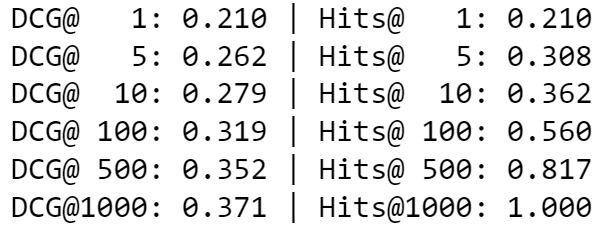

## Часть 3. Представления для неизвестных слов. (2 балла)

<font color='red'>**Оцените долю слов в выборке, для которых нет эмбеддинга в модели.**</font>

In [88]:
valid_emb_words = set()
valid_words = set()
for line in tqdm.tqdm(validation):
    q, *ex = line
    q, ex = text_prepare(q), [text_prepare(e) for e in ex] 
    for s in list(q) + ex:
        for w in s.split():
            valid_words.add(w)
            if w in wv_embeddings.vocab.keys():
                valid_emb_words.add(w) 

print('Proportion of words without embedding: {}'.format(round(1 - len(valid_emb_words) / len(valid_words),3)))

100%|██████████████████████████████████████████████████████████████████████████████| 3760/3760 [18:45<00:00,  3.34it/s]


Proportion of words without embedding: 0.56311


Для того, что получить представления для неизвестного слова, воспользуемся следующим подходом:
    
1. Будем восстанавливать эмбеддинг неизвестного слова как сумму эмбеддингов буквенных триграмм. Например, слово where должно представляться суммой триграмм _wh, whe, her, ere, re_

2. В качестве обучающих данных будем использовать слова, для которых есть эмбеддинг в модели. Будем обучать эмбеддинги триграмм по выборке эмбеддингов с помощью функционала MSE:

$$L = \sum_{w \in W_{known}}\| f_{\theta}(w) - v_w \|^2 \to \min_{\theta}$$

где:

* $W_{known}$ — множество известных модели слов
* $f_{\theta}(w)$ — сумма эмбеддингов триграмм слова $w$
* $v_w$ — эмбеддинг слова $w$
* $\theta$ — веса эмбеддингов триграмм

<font color='red'>**Реализуйте предложенную модель ниже.**</font>

Используйте класс nn.EmbeddingBag для построения среднего вектора представлений.

In [22]:
import torch
import torch.nn as nn

In [23]:
from nltk import ngrams
import tqdm

In [24]:
len(list(wv_embeddings.vocab.keys()))

500000

In [25]:
def get_word_trigramms(word):
    word_trigramms = ngrams(' '+word+' ', 3)
    trigramms = [''.join(x) for x in word_trigramms]
    return trigramms

In [26]:
get_word_trigramms('where')

[' wh', 'whe', 'her', 'ere', 're ']

In [27]:
trigramms = set()
words = set()
for line in tqdm.tqdm(prep_validation):
    for ques in line:
        for word in ques.split():
            word_trigramms = get_word_trigramms(word)
            words.add(word)
            trigramms.update(word_trigramms)
trigramms = sorted(list(trigramms))
words = sorted(list(words))

NameError: name 'prep_validation' is not defined

In [28]:
tri_dict = dict(zip(trigramms, range(len(trigramms))))

In [29]:
from torch.utils.data import Dataset
from torchvision import transforms


class WV_dataset(Dataset):
    def __init__(self, wv_embeddings, tri_dict, words, dim=300):
        self.known_words = words
        indices = []
        for word in self.known_words:
            indices_ = [tri_dict[trigramm] for trigramm in get_word_trigramms(word)]
            indices.append(indices_)
        self.indices = np.array(indices)
        self.tri_dict = tri_dict        
        self.wv_embeddings = wv_embeddings

    def __getitem__(self, index):
        mask = np.zeros(len(self.tri_dict), dtype=int)
        mask[self.indices[index]] = 1
        return torch.from_numpy(mask).float(), torch.from_numpy(self.wv_embeddings[self.known_words[index]]).float()

    def __len__(self):
        return len(self.known_words)

In [30]:
class TrigrammEmbeddingsModel(nn.Module):
    def __init__(self, mask_dim, dim=300):
        """
        all_known_tokens : list of str
        
        embedding_dim : int
        """
        super().__init__()
        self.linear = nn.Linear(mask_dim, dim, bias=False)
    
    def forward(self, x):
        return self.linear(x)
    
    def reset_parameters(self):
        for (name, module) in self._modules.items():
            module.reset_parameters()

In [31]:
words = [x for x in words if x in wv_embeddings.vocab.keys()]

In [32]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device ='cpu'

In [33]:
device

'cuda'

In [145]:
dataset = WV_dataset(wv_embeddings, tri_dict, words)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False, num_workers=0.)

net = TrigrammEmbeddingsModel(mask_dim=len(tri_dict))
net = net.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.8)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)

In [160]:
def train(epoch):
    net.train()
    train_loss = 0
    
    for batch, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    scheduler.step()
    lr = scheduler.optimizer.param_groups[0]['lr']

In [161]:
net.reset_parameters()

for epoch in range(5000):
    train(epoch)
    if epoch % 250 == 0:
        torch.save(net.state_dict(), "./nn/net_{0:05d}.pwf".format(epoch))

KeyboardInterrupt: 

In [148]:
torch.save(net.state_dict(), "./nn/net_{0:05d}.pwf".format(epoch))

In [150]:
net.load_state_dict(torch.load('./nn/net_02513.pwf'))

<All keys matched successfully>

In [151]:
def net_que_to_vec(question, embeddings, net, tri_dict, dim=300):
    mean_vec = np.zeros(300)
    count = 0
    words = question.split()

    for word in words:
        if word in embeddings.vocab.keys():
            count += 1
            mean_vec += embeddings[word]
        else:
            i = 0
            for trigramm in get_word_trigramms(word):
                if trigramm in tri_dict.keys():
                    mask = np.zeros(len(tri_dict), dtype=int)
                    indices = tri_dict[trigramm]
                    mask[indices] = 1
                    mask = torch.from_numpy(mask).float().to(device)
                    net.eval()
                    vec = net(mask).cpu().detach().numpy()
                    mean_vec += vec
                    i += 1
                else:
                    print('Lost trigramm: ', trigramm)
            if i > 0:
                count += 1
                
    if count != 0:
        mean_vec /= count
    return mean_vec

In [152]:
from sklearn.metrics.pairwise import cosine_similarity
wv_ranking = []

for line in tqdm.tqdm(prep_validation):
    question, *candidates = line
    que_vector = net_que_to_vec(question, wv_embeddings, net, tri_dict).reshape((1, -1))
    cand_vectors = [net_que_to_vec(candidate, wv_embeddings, net, tri_dict).reshape((1, -1)) for candidate in candidates]
    scores = np.array([cosine_similarity(cand_vector, que_vector)[0] for cand_vector in cand_vectors]).T[0]
    sort_indices = np.argsort(scores)[::-1]
    ranks = list(zip(np.arange(len(candidates))[sort_indices], np.array(candidates)[sort_indices]))
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)


 48%|███████████████████████████████████▋                                      | 1814/3760 [2:57:17<3:29:41,  6.47s/it]

KeyboardInterrupt: 

сори, я не до отранжировал, но тем не менее я увидел что качество по нашим метрикам улучшилось а значит все это было не зря
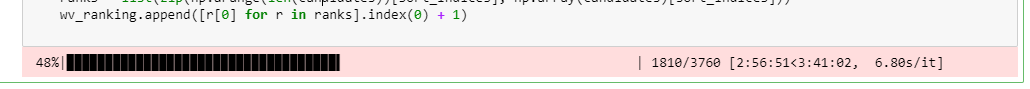

In [155]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.382 | Hits@   1: 0.382
DCG@   5: 0.451 | Hits@   5: 0.514
DCG@  10: 0.469 | Hits@  10: 0.568
DCG@ 100: 0.507 | Hits@ 100: 0.757
DCG@ 500: 0.527 | Hits@ 500: 0.914
DCG@1000: 0.536 | Hits@1000: 1.000


<font color='red'>** Обучите модель. Оцените, как изменилось качество. Сделайте выводы.**</font>

Если вы всё реализовали правильно, качество решения должно вырасти.

## Бонусная часть: векторные представления StarSpace (2 балла)

В бонусной части вам предлгается обучить эмбеддинги специально для задачи поиска дубликатов с помощью пакета [StarSpace](https://github.com/facebookresearch/StarSpace). К сожалению, его нельзя запустить на Windows, поэтому в этом случае мы рекоммендуем использовать готовый [docker container](https://github.com/hse-aml/natural-language-processing/blob/master/Docker-tutorial.md) с пошаговыми инструкциями или воспользоваться платформой google colab.

Данная модель все еще представляет вопросы с помощью усреднения векторов слов, однако обучается по размеченной выборке пар близких вопросов. Это позволяет обучить вектора, которые лучше подходят для конкретной задачи. Напомним, что в модели word2vec обучение происходят по парам близких слов, и на этапе обучения модель ничего не знает о наших планах по их усреднению в пост-обработке.


### Как выбрать  параметры модели?

Ниже приведены некоторые рекомендации, с которых можно начать свои эксперименты.

- Обучение на парах близких предложений соответствует режиму *trainMode = 3*.
- Используйте метод оптимизации adagrad (параметр *adagrad=True*).
- Установите длину фразы равной 1 (параметр *ngrams*), чтобы получить только вектора слов.
- Не используйте большое количество эпох (5 должно быть достаточно).
- Поэкспериментируйте с несколькими размерностями *dim* (например, от 100 до 300).
- Для сравнения векторов используйте *косинусную меру*.
- Установите *minCount* больше 1 (например, 2), если вы не хотите получить вектора для редко встречающихся слов.
- Параметр *verbose=True* будет показывать вам прогресс процесса обучения.
- Параметр *negSearchLimit* отвечает за число отрицательных примеров, которые используются в обучении, рекомендованное значение 10.
- Для ускорения обучения мы рекоммендуем поставить *шаг обучения (learning rate)* равным 0.05.

<font color='red'>** Обучите вектора StarSpace для униграм на обучающей выборке. Не забудьте использовать предобработанную версию данных. **</font>

Если вы следовали инструкциям правильно, то процесс обучения займет около 1 часа. Размер словаря полученных векторных представлений должен быть порядка 100000 (число строк в полученном файле). 

не справился с пошаговым гайдом((

Ниже вы можете проверить качество работы вашей модели. Так как обучение происходило для конкретной задачи на размеченных данных, то ожидается, что это решение будет иметь более высокое качество.

In [ ]:
starspace_embeddings = ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [ ]:
ss_prepared_ranking = []
for line in prepared_validation:
    q, *ex = line
    ranks = rank_candidates(q, ex, starspace_embeddings, 100)
    ss_prepared_ranking.append([r[0] for r in ranks].index(0) + 1)

In [ ]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(ss_prepared_ranking, k), 
                                              k, hits_count(ss_prepared_ranking, k)))

<font color='red'>**Опишите результаты ваших экспериментов, сделайте выводы.**</font>